In [46]:
%matplotlib inline

In [2]:
# import libraries 

import pandas as pd

# this is here to shut off some annoying warnings from pandas
pd.options.mode.chained_assignment = None

# matplotlib is one of the main plotting libraries we're going to use
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# the other plotting library is seaborn - we'll use both during the class

import seaborn as sns

# numpy and scipy are for handling numerical and scientific data

import numpy as np
import scipy as sp

import statsmodels.formula.api as smf # basic statistical modeling

from scipy.stats.stats import pearsonr 

import os

from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import nbinom
from scipy.stats.mstats import gmean

from pandas.tools.plotting import scatter_matrix



In [3]:
# load dataframe with expression data

datafile = "data/barton/Barton_combined_Ygenes.tsv"
df = pd.read_csv(datafile, sep='\t')   # the sep='\t' tells pandas that it is a tab separated file

df = df.set_index('Gene')

df.head()

,WT_rep01,WT_rep02,WT_rep03,WT_rep04,WT_rep05,WT_rep06,WT_rep07,WT_rep08,WT_rep09,WT_rep10,...,Snf2_rep39,Snf2_rep40,Snf2_rep41,Snf2_rep42,Snf2_rep43,Snf2_rep44,Snf2_rep45,Snf2_rep46,Snf2_rep47,Snf2_rep48
Gene,,,,,,,,,,,,,,,,,,,,,
YAL001C,311,421,382,550,403,929,499,414,379,482,...,1235,641,673,562,734,773,611,911,749,667
YAL002W,266,451,434,616,441,913,503,431,376,507,...,851,529,406,367,555,623,436,586,556,445
YAL003W,6387,10292,7440,12994,11001,16296,10198,10137,11298,8425,...,11071,6280,7442,5177,7664,6827,7081,7010,6800,5943
YAL004W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YAL005C,10331,10088,10932,19029,9711,18561,12207,16760,12184,10562,...,15617,8459,9813,8600,11531,8748,9513,11423,7835,8836


In [17]:
wt_cols = [c for c in df.columns if c.startswith("WT")]
snf2_cols = [c for c in df.columns if c.startswith("Snf2")]
all_cols = wt_cols + snf2_cols

In [27]:
df['WT_ave']   = df[wt_cols].mean(axis=1)
df['Snf2_ave'] = df[snf2_cols].mean(axis=1)
df['all_ave']  = df[all_cols].mean(axis=1)

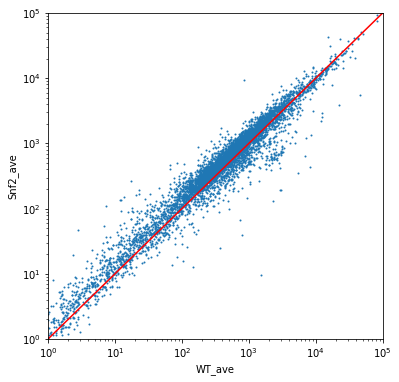

In [38]:
c1 = 'WT_ave'
c2 = 'Snf2_ave'

x = df[c1]
y = df[c2]

plt.figure(figsize=(6,6))
plt.scatter(x,y,s=1)
plt.xlabel(c1)
plt.ylabel(c2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,100000)
plt.ylim(1,100000)

xline = np.linspace(1,100000,500)
yline = xline
plt.plot(xline,yline,c='red')

In [39]:
# normalize 

for c in all_cols:
    # calculate the median 
    ratios = (df[c]/df['WT_ave']).replace([np.inf, -np.inf], np.nan).dropna()
    colnorm = np.median(ratios)
    df[c] = df[c] / colnorm

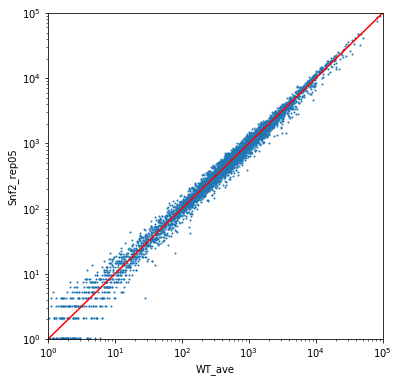

In [37]:
c1 = 'WT_ave'
c2 = 'Snf2_rep05'

x = df[c1]
y = df[c2]

plt.figure(figsize=(6,6))
plt.scatter(x,y,s=1)
plt.xlabel(c1)
plt.ylabel(c2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1,100000)
plt.ylim(1,100000)

xline = np.linspace(1,100000,500)
yline = xline
plt.plot(xline,yline,c='red')

In [ ]:
# so now we have nicely normalized data, what do we do with it?

In [40]:
#
# create a matrix to store correlation
#

datalen = len(all_cols)
corrdata = np.zeros( (datalen,datalen))

for i1,e1 in enumerate(all_cols):
    for i2,e2 in enumerate(all_cols):
        corrdata[i1][i2] = pearsonr(df[e1],df[e2])[0] 
      

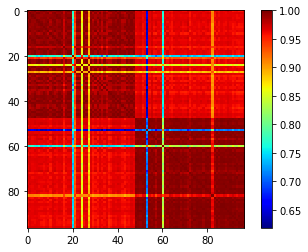

In [41]:
# plot data as a heatmap 
# this option maps every cell in the table into a colored pixel
# the cmap options controls how the mapping is done

plt.imshow(corrdata, cmap='jet')
plt.colorbar()

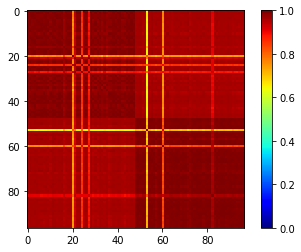

In [42]:
# plot data as a heatmap 
# this option maps every cell in the table into a colored pixel
# the cmap, vmin and vmax options controls how the mapping is done

plt.imshow(corrdata, cmap='jet',vmin=0, vmax=1.0)
plt.colorbar()

### Identifying differentially expressed genes

Let's imagine we did an experiment with no replicates - one sample per consdition. 

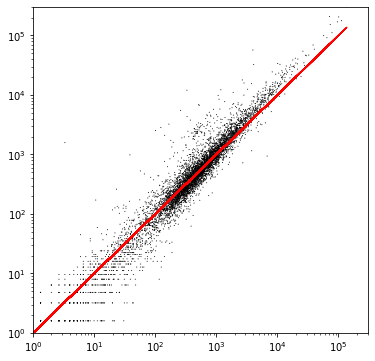

In [45]:

c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

x = df[c1]
y = df[c2]

maxval = max(np.max(x),np.max(y))

plt.figure(figsize = (6,6))
plt.xscale("log")
plt.yscale("log")
plt.xlim(1,maxval)
plt.ylim(1,maxval)

plt.scatter(x, y, s = 1, c='black', edgecolor = 'none')
plt.plot(x,x,'r-')

How do we identify outliers? Many people start by saying genes up or down 2x. So let's look at those.

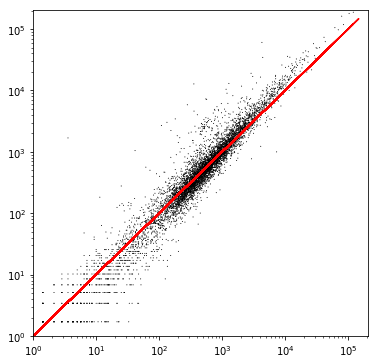

In [25]:
c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

x = df[c1]
y = df[c2]

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log")
ax.set_yscale("log")
ax.scatter(x, y, s = 1, c = 'black', edgecolor = 'none')
ax.plot(x,x,'r-')

OK, now we can begin to look for differentially expressed genes.

In [48]:
# lets make a function to plot differentially expressed genes

def plot_de(df,c1,c2):
    
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1)
    maxval = np.max(np.append(df[c1].values,df[c1].values))
    ax.set_xlim(1,maxval)
    ax.set_ylim(1,maxval)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("WT")
    ax.set_ylabel("Mutant")

    ldf = df[(df[c1] > 1) & (df[c2] > 1) & (df[c1]/df[c2] > 2.0)][[c1,c2]] 
    ax.scatter(ldf[c1],ldf[c2],s=1,c='green',label='down 2x (n = %d)' % len(ldf))

    ldf = df[(df[c1] > 1) & (df[c2] > 1) & (df[c2]/df[c1] > 2.0)][[c1,c2]] 
    ax.scatter(ldf[c1],ldf[c2],s=1,c='red',label='up 2x (n = %d)' % len(ldf))

    plt.legend()

    ldf = df[(df[c1] > 1) & (df[c2] > 1) & (df[c2]/df[c1] < 2.0) & (df[c1]/df[c2] < 2.0)][[c1,c2]] 
    ax.scatter(ldf[c1],ldf[c2],s=1,c='black',alpha = .25)

    ax.plot(x,x,'b-')


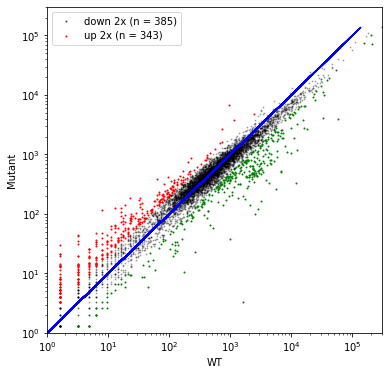

In [49]:
plot_de(df,'WT_rep01','Snf2_rep01')

Text(0, 0.5, 'log(fold change) experiment 2')

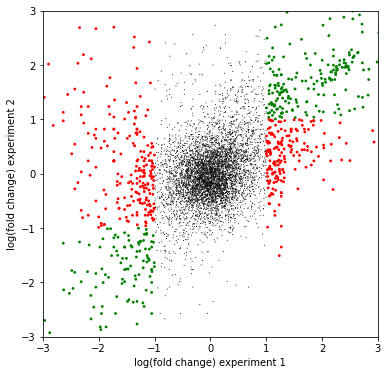

In [51]:
# Does this replicate?

wt1 = 'WT_rep01'
wt2 = 'WT_rep02'

mut1 = 'Snf2_rep01'
mut2 = 'Snf2_rep02'

cols = [wt1,wt2,mut1,mut2]

# create a temporary data frame where any row with values < 1 are removed

tdf = df[cols][df > 1].dropna()

x = np.log2(tdf[wt1]/tdf[mut1]).values
y = np.log2(tdf[wt2]/tdf[mut2]).values

c = []
s = []

for i,vx in enumerate(x):    
    if x[i] > 1.0: 
        if y[i] > 1.0:
            c.append('g')
            s.append(8)
        else:
            c.append('r')
            s.append(8)
    elif x[i] < -1.0:
        if y[i] < -1.0:
            c.append('g')
            s.append(8)
        else:
            c.append('r')
            s.append(8)
    else:
        c.append('k')
        s.append(1)

plt.figure(figsize = (6,6))
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.scatter(x, y, s = s, c = c, edgecolor = 'none')
plt.xlabel("log(fold change) experiment 1")
plt.ylabel("log(fold change) experiment 2")
#ax.plot(x,x,'r-')

Clearly we need more than just one or two samples to accurately identify reproducible differences between samples. But how many do we need?

### Looking at individual genes

Now we are going to start looking at individual genes. The first thing we're doing to do is sort based on the magnitude of the ratio between the WT and Snf2 averages and then plot the individual values.

In [33]:
cols = ['ave_wt','ave_mut']

tdf = df[cols][df[cols].max(axis=1) > 10].dropna()


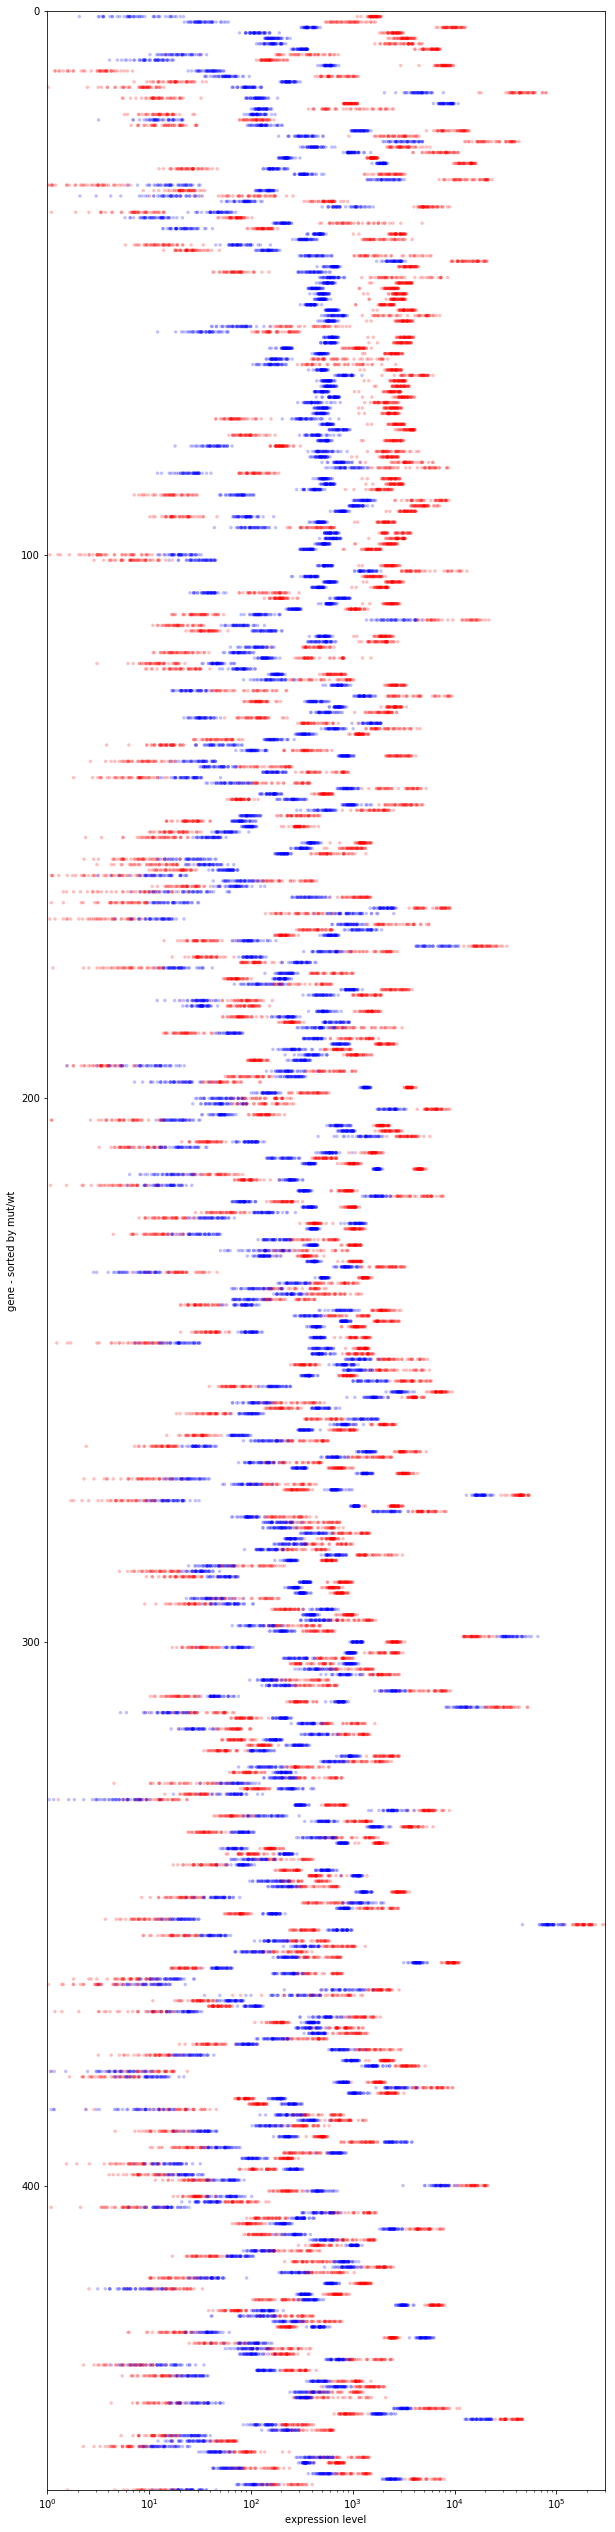

In [34]:
# Sort based ratio of snf2 ave vs wt ave

aved = {}

cols = ['ave_wt','ave_mut']

tdf = df[cols][df[cols].max(axis=1) > 10].dropna()

for index, row in tdf.iterrows():
    mut = row['ave_mut']
    wt = row['ave_wt']
    aved[index] = abs(np.log2(mut/wt))
    
aved = {k:v for (k,v) in aved.items() if v > 1.0}

aveds = sorted(aved.keys(),key = lambda x: aved[x], reverse=True)

mut_ind = []
mut = []
wt_ind = [] 
wt = []

for i,t in enumerate(aveds):
    for c in exps_filt['mut']:
        mut_ind.append(i+1)
        mut.append(df.loc[t,c])
    for c in exps_filt['wt']:
        wt_ind.append(i+1)
        wt.append(df.loc[t,c])
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,max(wt + mut))
ax.set_ylim(max(wt_ind + mut_ind),0)
ax.set_xscale("log", nonposx='clip')
ax.set_xlabel("expression level")
ax.set_ylabel("gene - sorted by mut/wt")
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(mut,mut_ind,s=12,alpha=.25,c='b',edgecolor='none')